In [30]:
import torch
import random
import os
import json

import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm

from dataloaders.dataset import CityscapesSegmentation
from utils.custom_utils import calculate_dice_miou

In [31]:
CFG = {
    'NUM_CLASS':8,
    'EPOCHS':500,
    'LR':0.01,
    'BATCH_SIZE':4,
    'SEED':41,
}

model_save_dir = '/home/vision/gyuil/lab/Segmentation/save'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [33]:
base_size = (1024, 2048)
crop_size = (512, 1024)

# cityscapes_train = CityscapesSegmentation(base_size, crop_size, split='train')
cityscapes_val = CityscapesSegmentation(base_size, crop_size, split='val')
# cityscapes_test = CityscapesSegmentation(base_size, crop_size, split='test')

# train_dataloader = DataLoader(cityscapes_train, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=4)
val_dataloader = DataLoader(cityscapes_val, batch_size=1, shuffle=True, num_workers=4)
# test_dataloader = DataLoader(cityscapes_test, batch_size=2, shuffle=True, num_workers=4)

Found 500 val images


In [34]:
next(iter(val_dataloader))[0].shape

torch.Size([1, 3, 512, 1024])

In [35]:
num_class = cityscapes_val.NUM_CLASSES

model = smp.UnetPlusPlus(
                        # encoder=resnet50,
                        encoder_name="resnet101",
                        encoder_weights="imagenet",
                        in_channels=3,
                        classes=num_class+1,
                        patch_attention=False,
                        dataset_type="cityscapes" # #aitod
                    )

model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=CFG['LR'], momentum=0.9, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255).to(device) ### without focal loss

https://download.pytorch.org/models/resnet101-5d3b4d8f.pth


In [75]:
state_dict = torch.load('/home/vision/gyuil/lab/Segmentation/save/490_unetpp')
model.load_state_dict(state_dict)

/tmp/ipykernel_117894/860435351.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/home/vision/gyuil/lab/Segmentation/save/490_unetpp')


<All keys matched successfully>

In [76]:
model.eval()
test_loss = 0
test_dice_score = 0
test_iou_score = 0
miou = 0
mean_dice = 0

for data in tqdm(val_dataloader) :
    
    images = data[0].cuda()
    masks = data[1].cuda()

    masks[masks == 255.] = num_class

    outputs = model(images)

    # loss
    loss = criterion(outputs.float(), masks.long())
    preds = torch.softmax(outputs, dim=1).cpu()
    preds = torch.argmax(preds, dim=1).numpy()

    test_loss += loss.item()

    # dice score
    dice, iou = calculate_dice_miou(preds, masks.squeeze(1).cpu().numpy(), num_classes=num_class+1)
    test_iou_score += iou.item()
    test_dice_score += dice.item()
    miou += calculate_miou(preds, masks.squeeze(1).cpu().numpy())
    mean_dice += calculate_mean_dice(preds, masks.squeeze(1).cpu().numpy())
    

    # del masks, images

test_loss = test_loss/len(val_dataloader)
test_dice = test_dice_score/len(val_dataloader)
test_iou = test_iou_score/len(val_dataloader)

100%|██████████| 500/500 [00:53<00:00,  9.31it/s]


In [77]:
mean_dice / len(val_dataloader), miou / len(val_dataloader)

(0.725464936617343, 0.6702312965107236)

: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


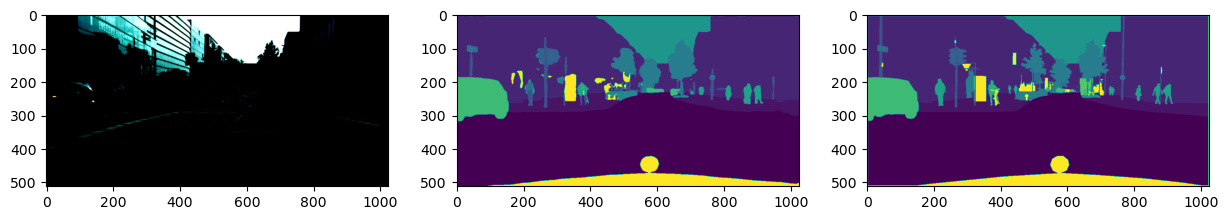

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
masks = masks.squeeze(1).cpu().numpy()

plt.subplot(1,3,1)
plt.imshow(images.squeeze().cpu().numpy().transpose(1,2,0))

plt.subplot(1,3,2)
plt.imshow(preds.transpose(1,2,0))

plt.subplot(1,3,3)
plt.imshow(masks.transpose(1,2,0))

In [40]:
dice, iou = calculate_dice_miou(preds, masks, num_classes=num_class+1)
iou

0.49821610098655045

In [46]:
import numpy as np

def intersect_and_union(pred, label, num_classes, ignore_index=255):
    """교집합과 합집합을 계산합니다.
    
    Args:
        pred (np.ndarray): 예측 마스크 (H, W).
        label (np.ndarray): 실제 마스크 (H, W).
        num_classes (int): 클래스 수.
        ignore_index (int): 무시할 인덱스.

    Returns:
        np.ndarray: 각 클래스별 교집합 영역.
        np.ndarray: 각 클래스별 합집합 영역.
    """
    # 무시할 인덱스 마스크 생성
    mask = (label != ignore_index)
    pred = pred[mask]
    label = label[mask]

    # 각 클래스에 대한 교집합 및 합집합 계산
    intersection = np.histogram(pred[pred == label], bins=num_classes, range=(0, num_classes))[0]
    pred_area = np.histogram(pred, bins=num_classes, range=(0, num_classes))[0]
    label_area = np.histogram(label, bins=num_classes, range=(0, num_classes))[0]
    union = pred_area + label_area - intersection

    return intersection, union, pred_area, label_area

def calculate_miou(mask, pred, num_classes=19, ignore_index=255):
    """mIoU 계산.
    
    Args:
        mask (np.ndarray): 실제 마스크 (H, W).
        pred (np.ndarray): 예측 마스크 (H, W).
        num_classes (int): 클래스 수. 기본값은 19.
        ignore_index (int): 무시할 클래스 인덱스. 기본값은 255.
        
    Returns:
        float: mIoU 값.
    """
    intersection, union, _, _ = intersect_and_union(pred, mask, num_classes, ignore_index)

    # union이 0인 경우 iou를 1로 설정하여 처리
    iou = np.where(union == 0, 1, (intersection + 1) / (union + 1))
    miou = np.nanmean(iou)  # NaN은 무시하고 평균 계산
    return miou

def calculate_mean_dice(mask, pred, num_classes=19, ignore_index=255):
    """mean Dice 계산.
    
    Args:
        mask (np.ndarray): 실제 마스크 (H, W).
        pred (np.ndarray): 예측 마스크 (H, W).
        num_classes (int): 클래스 수. 기본값은 19.
        ignore_index (int): 무시할 클래스 인덱스. 기본값은 255.
        
    Returns:
        float: mean Dice 값.
    """
    intersection, _, pred_area, label_area = intersect_and_union(pred, mask, num_classes, ignore_index)

    # Dice Coefficient 계산
    dice = np.where((pred_area + label_area) == 0, 1, (2 * intersection + 1) / (pred_area + label_area + 1))
    mean_dice = np.nanmean(dice)  # NaN은 무시하고 평균 계산
    return mean_dice


In [42]:
calculate_miou(masks, preds)

0.6293851605143392